# 01 — Feasibility: Linking TCGA/GDC Histopathology Slides to RNA-seq

## Why this notebook exists
Before any modeling, we need to confirm that TCGA (via the GDC) provides **paired** data for the same patients:
- Whole-slide histopathology images (H&E)
- RNA-seq gene expression quantification
- Basic clinical metadata

## What we will deliver
1) A **paired-case feasibility summary** (counts + plot)
2) A small **paired cohort manifest** (case IDs + slide file IDs + RNA-seq file IDs + minimal clinical fields)
3) Saved artifacts in `outputs/feasibility/` for reproducibility and sharing

In [1]:
import os
import json
import time
from datetime import datetime

import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# USER CONFIG
# -----------------------------
PROJECT = "TCGA-BRCA"  # alternatives: "TCGA-COAD", "TCGA-LUAD", ...
DEMO_N_CASES = 15      # keep small for fast demo + meeting

# -----------------------------
# OUTPUT PATHS
# -----------------------------
OUT_DIR = os.path.join("outputs", "feasibility")
os.makedirs(OUT_DIR, exist_ok=True)

print("Project:", PROJECT)
print("Output dir:", OUT_DIR)
print("Timestamp:", datetime.now().isoformat(timespec="seconds"))


Project: TCGA-BRCA
Output dir: outputs\feasibility
Timestamp: 2025-12-25T06:57:18


In [3]:
GDC = "https://api.gdc.cancer.gov"

def gdc_post(endpoint: str, payload: dict, timeout: int = 60) -> dict:
    """
    POST request to a GDC endpoint and return JSON response.
    Includes basic error reporting that is helpful during live demos.
    """
    url = GDC + endpoint
    try:
        r = requests.post(url, json=payload, timeout=timeout)
        r.raise_for_status()
        return r.json()
    except requests.exceptions.RequestException as e:
        raise RuntimeError(f"GDC request failed: {e}\nEndpoint: {url}\nPayload:\n{json.dumps(payload, indent=2)}")

def safe_json_normalize(hits):
    """Convert list[dict] to DataFrame safely even if empty."""
    if hits is None or len(hits) == 0:
        return pd.DataFrame()
    return pd.json_normalize(hits)


## Definition: what is a "paired case"?

A **paired case** is a patient (case_id) that has BOTH:
- at least one **Slide Image** file (histopathology WSI)
- at least one **Gene Expression Quantification** file (RNA-seq output)

Important: GDC typically provides **data**, not biological labels (subtypes/immune classes).
Subtypes will be derived later from RNA-seq.


In [4]:
# Query A: slide images
payload_slide = {
    "filters": {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT]}},
            {"op": "in", "content": {"field": "data_type", "value": ["Slide Image"]}},
        ]
    },
    "format": "JSON",
    "size": 0
}

# Query B: RNA-seq gene expression quantification
payload_rna = {
    "filters": {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT]}},
            {"op": "in", "content": {"field": "data_type", "value": ["Gene Expression Quantification"]}},
        ]
    },
    "format": "JSON",
    "size": 0
}


In [5]:
slide_files_total = gdc_post("/files", payload_slide)["data"]["pagination"]["total"]
rna_files_total   = gdc_post("/files", payload_rna)["data"]["pagination"]["total"]

print("Total Slide Image files:", slide_files_total)
print("Total RNA Gene Expression Quantification files:", rna_files_total)


Total Slide Image files: 3112
Total RNA Gene Expression Quantification files: 1231


In [6]:
def get_case_ids_from_files_query(payload: dict, max_size: int = 20000) -> set:
    """
    Pulls unique case_ids from a /files query.
    For TCGA projects this typically works well for feasibility checks.
    """
    p = dict(payload)  # shallow copy
    p["size"] = max_size
    p["fields"] = "cases.case_id"
    p["format"] = "JSON"

    res = gdc_post("/files", p)
    hits = res["data"]["hits"]

    case_ids = []
    for h in hits:
        for c in h.get("cases", []):
            case_ids.append(c.get("case_id"))
    return set([x for x in case_ids if x is not None])

slide_case_ids = get_case_ids_from_files_query(payload_slide)
rna_case_ids   = get_case_ids_from_files_query(payload_rna)

paired_case_ids = sorted(list(slide_case_ids.intersection(rna_case_ids)))

print("Cases with slides:", len(slide_case_ids))
print("Cases with RNA:", len(rna_case_ids))
print("Paired cases (slides ∩ RNA):", len(paired_case_ids))


Cases with slides: 1098
Cases with RNA: 1095
Paired cases (slides ∩ RNA): 1095


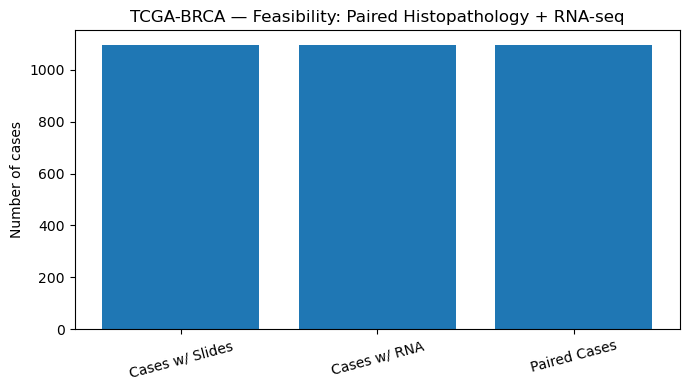

Saved plot: outputs\feasibility\tcga-brca_feasibility_summary.png


In [7]:
labels = ["Cases w/ Slides", "Cases w/ RNA", "Paired Cases"]
values = [len(slide_case_ids), len(rna_case_ids), len(paired_case_ids)]

plt.figure(figsize=(7,4))
plt.bar(labels, values)
plt.title(f"{PROJECT} — Feasibility: Paired Histopathology + RNA-seq")
plt.ylabel("Number of cases")
plt.xticks(rotation=15)
plt.tight_layout()

fig_path = os.path.join(OUT_DIR, f"{PROJECT.lower()}_feasibility_summary.png")
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved plot:", fig_path)


In [8]:
if len(paired_case_ids) == 0:
    raise RuntimeError("No paired cases found. Try a different PROJECT or check GDC availability.")

demo_case_ids = paired_case_ids[:DEMO_N_CASES]
print("Demo cohort cases:", len(demo_case_ids))
print("First 3 case_ids:", demo_case_ids[:3])


Demo cohort cases: 15
First 3 case_ids: ['001cef41-ff86-4d3f-a140-a647ac4b10a1', '0045349c-69d9-4306-a403-c9c1fa836644', '00807dae-9f4a-4fd1-aac2-82eb11bf2afb']


In [9]:
payload_cases = {
    "filters": {"op": "in", "content": {"field": "case_id", "value": demo_case_ids}},
    "format": "JSON",
    "size": len(demo_case_ids),
    "fields": ",".join([
        "case_id",
        "submitter_id",
        "project.project_id",
        "diagnoses.primary_diagnosis",
        "diagnoses.tumor_stage",
        "diagnoses.vital_status",
        "diagnoses.days_to_death",
        "diagnoses.days_to_last_follow_up"
    ])
}

cases_hits = gdc_post("/cases", payload_cases)["data"]["hits"]
df_cases = safe_json_normalize(cases_hits)

df_cases.head(3)


,id,case_id,submitter_id,diagnoses,project.project_id
0,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,"[{'days_to_last_follow_up': 3102.0, 'primary_d...",TCGA-BRCA
1,00a2d166-78c9-4687-a195-3d6315c27574,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,"[{'days_to_last_follow_up': 5.0, 'primary_diag...",TCGA-BRCA
2,00b11ca8-8540-4a3d-b602-ec754b00230b,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,"[{'primary_diagnosis': 'Intraductal carcinoma,...",TCGA-BRCA


In [10]:
payload_demo_slides = {
    "filters": {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.case_id", "value": demo_case_ids}},
            {"op": "in", "content": {"field": "data_type", "value": ["Slide Image"]}},
        ]
    },
    "format": "JSON",
    "size": 5000,
    "fields": "file_id,file_name,cases.case_id"
}

slides_hits = gdc_post("/files", payload_demo_slides)["data"]["hits"]
df_slides = safe_json_normalize(slides_hits)

df_slides.head(3)


,id,cases,file_name,file_id
0,cea82b7d-135a-49d5-b4f6-3fb0215f7188,[{'case_id': '0045349c-69d9-4306-a403-c9c1fa83...,TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5...,cea82b7d-135a-49d5-b4f6-3fb0215f7188
1,7814f2d4-f315-421f-a359-ce9668b45b4a,[{'case_id': '0045349c-69d9-4306-a403-c9c1fa83...,TCGA-A1-A0SB-01A-01-TS1.ed80b57e-ce46-45d6-b8c...,7814f2d4-f315-421f-a359-ce9668b45b4a
2,d5077222-c048-4694-b7aa-7d5a47d13dc3,[{'case_id': '01f50abf-fc15-446e-9d07-edeecc54...,TCGA-E2-A155-01A-01-TSA.555fff50-3656-4fe1-bd5...,d5077222-c048-4694-b7aa-7d5a47d13dc3


In [11]:
payload_demo_rna = {
    "filters": {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "cases.case_id", "value": demo_case_ids}},
            {"op": "in", "content": {"field": "data_type", "value": ["Gene Expression Quantification"]}},
        ]
    },
    "format": "JSON",
    "size": 5000,
    "fields": "file_id,file_name,analysis.workflow_type,cases.case_id"
}

rna_hits = gdc_post("/files", payload_demo_rna)["data"]["hits"]
df_rna = safe_json_normalize(rna_hits)

df_rna.head(3)


,id,cases,file_name,file_id,analysis.workflow_type
0,0e0df72c-33c0-4e4f-939c-a4d45a6e1ea3,[{'case_id': '0045349c-69d9-4306-a403-c9c1fa83...,36125e17-48fd-4eea-874c-ed2e2e218402.rna_seq.a...,0e0df72c-33c0-4e4f-939c-a4d45a6e1ea3,STAR - Counts
1,ef227e3c-7a6d-4c43-945f-c1c7b410d50b,[{'case_id': '029ce650-5e5a-4100-8596-cd94300e...,dbb2f12c-e200-412a-9023-0126d6d69a52.rna_seq.a...,ef227e3c-7a6d-4c43-945f-c1c7b410d50b,STAR - Counts
2,e173c170-b7c6-4aa9-9f34-33cd02702d75,[{'case_id': '016caf42-4e19-4444-ab5d-6cf1e76c...,8d3d544f-6d1a-4cdc-8091-490311487ebd.rna_seq.a...,e173c170-b7c6-4aa9-9f34-33cd02702d75,STAR - Counts


In [12]:
def first_case_id(cases_list):
    if isinstance(cases_list, list) and len(cases_list) > 0:
        return cases_list[0].get("case_id")
    return None

# Attach case_id explicitly
if "cases" in df_slides.columns:
    df_slides["case_id"] = df_slides["cases"].apply(first_case_id)
else:
    df_slides["case_id"] = None

if "cases" in df_rna.columns:
    df_rna["case_id"] = df_rna["cases"].apply(first_case_id)
else:
    df_rna["case_id"] = None

# Minimal columns
df_slides_min = df_slides[["case_id", "file_id", "file_name"]].rename(
    columns={"file_id": "slide_file_id", "file_name": "slide_file_name"}
) if len(df_slides) else pd.DataFrame(columns=["case_id","slide_file_id","slide_file_name"])

df_rna_min = df_rna[["case_id", "file_id", "file_name", "analysis.workflow_type"]].rename(
    columns={"file_id": "rna_file_id", "file_name": "rna_file_name", "analysis.workflow_type": "rna_workflow"}
) if len(df_rna) else pd.DataFrame(columns=["case_id","rna_file_id","rna_file_name","rna_workflow"])

# Clinical columns (GDC can return nested diagnoses.0.* fields after normalize)
clinical_cols = [
    "case_id",
    "submitter_id",
    "project.project_id",
    "diagnoses.0.primary_diagnosis",
    "diagnoses.0.tumor_stage",
    "diagnoses.0.vital_status",
    "diagnoses.0.days_to_death",
    "diagnoses.0.days_to_last_follow_up"
]
for c in clinical_cols:
    if c not in df_cases.columns:
        df_cases[c] = None

df_cases_min = df_cases[clinical_cols].copy()

manifest = (
    df_cases_min
    .merge(df_slides_min, on="case_id", how="left")
    .merge(df_rna_min, on="case_id", how="left")
)

manifest.head(10)


,case_id,submitter_id,project.project_id,diagnoses.0.primary_diagnosis,diagnoses.0.tumor_stage,diagnoses.0.vital_status,diagnoses.0.days_to_death,diagnoses.0.days_to_last_follow_up,slide_file_id,slide_file_name,rna_file_id,rna_file_name,rna_workflow
0,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,TCGA-BRCA,None,None,None,None,None,3a9802b4-90f6-427e-9f28-742a2952e04b,TCGA-A2-A04W-01A-03-TSC.83981bb3-9dfd-4632-91c...,94468afc-faea-4091-af0f-d2df8aec37da,0781a18f-ce2a-478f-945e-49b2b8d7d941.rna_seq.a...,STAR - Counts
1,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,TCGA-BRCA,None,None,None,None,None,4491f313-0b2f-4a38-8a90-14145857b964,TCGA-A2-A04W-01A-03-BSC.57907e35-3c5d-4b06-873...,94468afc-faea-4091-af0f-d2df8aec37da,0781a18f-ce2a-478f-945e-49b2b8d7d941.rna_seq.a...,STAR - Counts
2,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-A2-A04W,TCGA-BRCA,None,None,None,None,None,38f61b93-b857-40d8-83b7-fbc3c52a5c3f,TCGA-A2-A04W-01Z-00-DX1.F7E7B945-2ADC-4741-8FC...,94468afc-faea-4091-af0f-d2df8aec37da,0781a18f-ce2a-478f-945e-49b2b8d7d941.rna_seq.a...,STAR - Counts
3,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,TCGA-BRCA,None,None,None,None,None,1eab7934-10a1-4d44-abb5-ee7c969de28f,TCGA-AN-A0AM-01A-01-TSA.63a22828-01b7-4b90-976...,e14858ca-8bb5-4d6d-906c-5d62722d90f8,fd6f4c9b-ee43-4939-8cfa-2e447aedbcf3.rna_seq.a...,STAR - Counts
4,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,TCGA-BRCA,None,None,None,None,None,af35bcd1-00e0-4400-8b0d-0abf457f950e,TCGA-AN-A0AM-01A-01-BSA.1736e9ff-6a00-45e7-8ab...,e14858ca-8bb5-4d6d-906c-5d62722d90f8,fd6f4c9b-ee43-4939-8cfa-2e447aedbcf3.rna_seq.a...,STAR - Counts
5,00a2d166-78c9-4687-a195-3d6315c27574,TCGA-AN-A0AM,TCGA-BRCA,None,None,None,None,None,2ef324e9-8032-4b1c-9552-60e892285f85,TCGA-AN-A0AM-01Z-00-DX1.169CE39A-DD54-46D8-8D0...,e14858ca-8bb5-4d6d-906c-5d62722d90f8,fd6f4c9b-ee43-4939-8cfa-2e447aedbcf3.rna_seq.a...,STAR - Counts
6,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,TCGA-BRCA,None,None,None,None,None,2c9c1bbe-dc6e-44ca-848e-3eb33ed5f914,TCGA-LL-A440-01A-01-TSA.7F50766F-CBFA-40A8-8B9...,e6f927ef-840f-438a-9559-863cc64f71e0,98447eef-e5af-4bfa-a215-7a1edd601c46.rna_seq.a...,STAR - Counts
7,00b11ca8-8540-4a3d-b602-ec754b00230b,TCGA-LL-A440,TCGA-BRCA,None,None,None,None,None,16923b13-722b-4b2a-8364-20592da16f73,TCGA-LL-A440-01Z-00-DX1.6E031FD6-236C-49FA-B92...,e6f927ef-840f-438a-9559-863cc64f71e0,98447eef-e5af-4bfa-a215-7a1edd601c46.rna_seq.a...,STAR - Counts
8,01263518-5f7c-49dc-8d7e-84b0c03a6a63,TCGA-A8-A07W,TCGA-BRCA,None,None,None,None,None,7ccc5a5b-d3f1-46da-8540-d8fbb7c6c06e,TCGA-A8-A07W-01A-01-TSA.eae41004-b3f5-4528-9e9...,aa89d193-05a1-4f7f-9291-b9cf646656de,e06580e9-0b4a-48f7-9522-d54229aefb2d.rna_seq.a...,STAR - Counts
9,01263518-5f7c-49dc-8d7e-84b0c03a6a63,TCGA-A8-A07W,TCGA-BRCA,None,None,None,None,None,a3119d3a-4666-4e42-a38f-14d6746a370c,TCGA-A8-A07W-01Z-00-DX1.5970CF33-D675-4AF4-800...,aa89d193-05a1-4f7f-9291-b9cf646656de,e06580e9-0b4a-48f7-9522-d54229aefb2d.rna_seq.a...,STAR - Counts


In [13]:
manifest_csv = os.path.join(OUT_DIR, f"{PROJECT.lower()}_paired_manifest_demo.csv")
manifest.to_csv(manifest_csv, index=False)

summary_txt = os.path.join(OUT_DIR, f"{PROJECT.lower()}_meeting_summary.txt")
with open(summary_txt, "w", encoding="utf-8") as f:
    f.write(f"Project: {PROJECT}\n")
    f.write(f"Slide files (total): {slide_files_total}\n")
    f.write(f"RNA files (total): {rna_files_total}\n")
    f.write(f"Cases with slides: {len(slide_case_ids)}\n")
    f.write(f"Cases with RNA: {len(rna_case_ids)}\n")
    f.write(f"Paired cases: {len(paired_case_ids)}\n")
    f.write(f"Demo cohort size: {len(demo_case_ids)}\n")
    f.write(f"Manifest CSV: {manifest_csv}\n")
    f.write(f"Plot PNG: {fig_path}\n")

print("Saved manifest:", manifest_csv)
print("Saved summary:", summary_txt)


Saved manifest: outputs\feasibility\tcga-brca_paired_manifest_demo.csv
Saved summary: outputs\feasibility\tcga-brca_meeting_summary.txt


## Summary of results
- “I validated feasibility using the GDC API.”
- “For **{PROJECT}**, there are **paired patients** with both histopathology slides and RNA-seq.”
- “I generated a reproducible **paired cohort manifest** (case IDs + file IDs), which de-risks the next steps.”

## Next step (after feasibility)
1) Build expression matrix from the RNA-seq quantification files  
2) Derive molecular targets (subtype or signatures) from RNA-seq  
3) Preprocess WSIs (tissue masking + tiling) and train a weakly supervised model (MIL)


,project,slide_files_total,rna_files_total,cases_with_slides,cases_with_rna,paired_cases,paired_rate_vs_rna_%,paired_rate_vs_slides_%
0,TCGA-BRCA,3112,1231,1098,1095,1095,100.0,99.73
1,TCGA-LUAD,1608,601,522,518,518,100.0,99.23
2,TCGA-COAD,1442,524,460,458,458,100.0,99.57


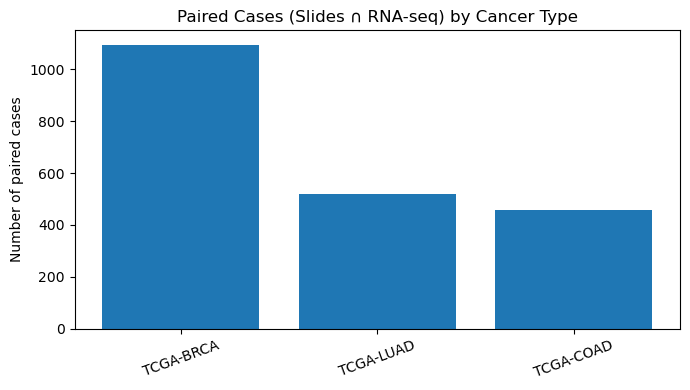

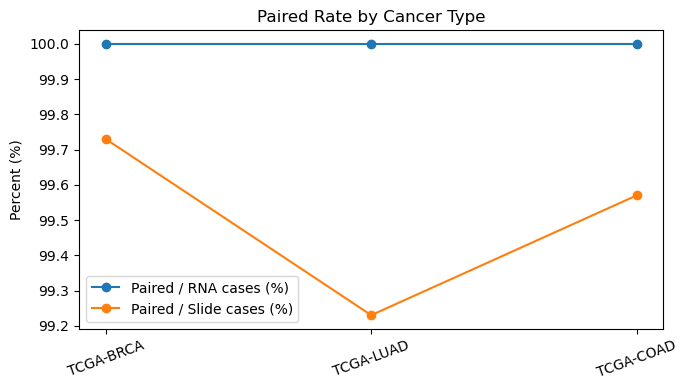

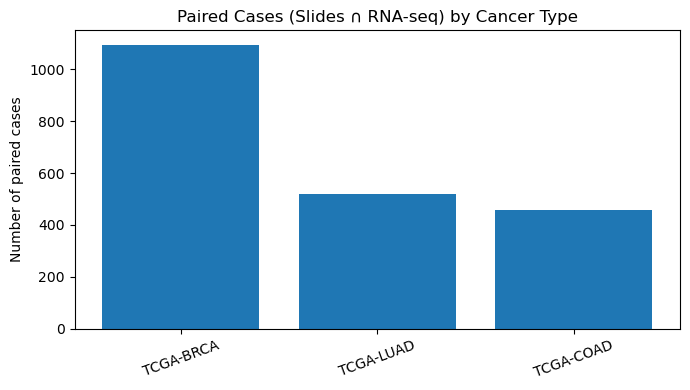

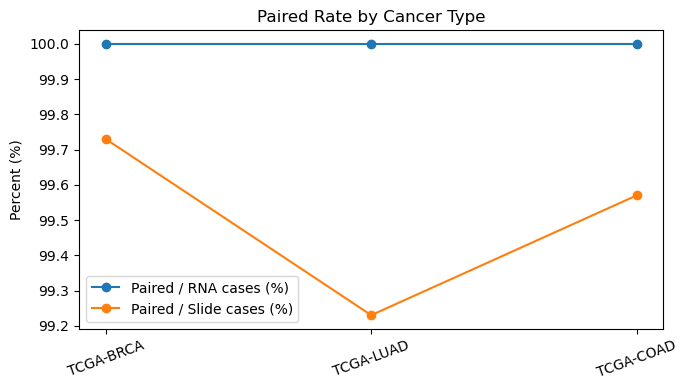

Saved: outputs\feasibility\multi_cancer_paired_cases.png
Saved: outputs\feasibility\multi_cancer_paired_rates.png


In [14]:
# ============================================================
# EXTENSION A — Multi-cancer feasibility comparison (framework)
# Paste this AFTER the first feasibility bar plot (after In[8])
# ============================================================

PROJECTS = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-COAD"]  # edit freely
MAX_SIZE = 20000

def build_payload_files(project_id: str, data_type: str):
    return {
        "filters": {"op": "and", "content": [
            {"op":"in","content":{"field":"cases.project.project_id","value":[project_id]}},
            {"op":"in","content":{"field":"data_type","value":[data_type]}}
        ]},
        "format": "JSON",
        "size": 0
    }

def count_total_files(project_id: str, data_type: str) -> int:
    res = gdc_post("/files", build_payload_files(project_id, data_type))
    return int(res["data"]["pagination"]["total"])

def get_case_ids(project_id: str, data_type: str, max_size: int = MAX_SIZE) -> set:
    p = build_payload_files(project_id, data_type)
    p = dict(p)
    p["fields"] = "cases.case_id"
    p["size"] = max_size
    res = gdc_post("/files", p)
    hits = res["data"]["hits"]
    case_ids = []
    for h in hits:
        for c in h.get("cases", []):
            if c.get("case_id"):
                case_ids.append(c["case_id"])
    return set(case_ids)

rows = []
for pid in PROJECTS:
    slide_total = count_total_files(pid, "Slide Image")
    rna_total   = count_total_files(pid, "Gene Expression Quantification")
    slide_cases = get_case_ids(pid, "Slide Image")
    rna_cases   = get_case_ids(pid, "Gene Expression Quantification")
    paired      = slide_cases.intersection(rna_cases)

    rows.append({
        "project": pid,
        "slide_files_total": slide_total,
        "rna_files_total": rna_total,
        "cases_with_slides": len(slide_cases),
        "cases_with_rna": len(rna_cases),
        "paired_cases": len(paired),
        "paired_rate_vs_rna_%": round((len(paired)/max(len(rna_cases),1))*100, 2),
        "paired_rate_vs_slides_%": round((len(paired)/max(len(slide_cases),1))*100, 2),
    })

df_multi = pd.DataFrame(rows).sort_values("paired_cases", ascending=False)
display(df_multi)

# Plot 1: Paired cases per cancer
plt.figure(figsize=(7,4))
plt.bar(df_multi["project"], df_multi["paired_cases"])
plt.title("Paired Cases (Slides ∩ RNA-seq) by Cancer Type")
plt.ylabel("Number of paired cases")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Plot 2: Paired rate (%)
plt.figure(figsize=(7,4))
plt.plot(df_multi["project"], df_multi["paired_rate_vs_rna_%"], marker="o", label="Paired / RNA cases (%)")
plt.plot(df_multi["project"], df_multi["paired_rate_vs_slides_%"], marker="o", label="Paired / Slide cases (%)")
plt.title("Paired Rate by Cancer Type")
plt.ylabel("Percent (%)")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.show()

# Save figures (optional)
fig_path_multi1 = os.path.join(OUT_DIR, f"multi_cancer_paired_cases.png")
fig_path_multi2 = os.path.join(OUT_DIR, f"multi_cancer_paired_rates.png")
plt.figure(figsize=(7,4))
plt.bar(df_multi["project"], df_multi["paired_cases"])
plt.title("Paired Cases (Slides ∩ RNA-seq) by Cancer Type")
plt.ylabel("Number of paired cases")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(fig_path_multi1, dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(df_multi["project"], df_multi["paired_rate_vs_rna_%"], marker="o", label="Paired / RNA cases (%)")
plt.plot(df_multi["project"], df_multi["paired_rate_vs_slides_%"], marker="o", label="Paired / Slide cases (%)")
plt.title("Paired Rate by Cancer Type")
plt.ylabel("Percent (%)")
plt.xticks(rotation=20)
plt.legend()
plt.tight_layout()
plt.savefig(fig_path_multi2, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", fig_path_multi1)
print("Saved:", fig_path_multi2)


,case_id,file_id,file_name,file_size,data_format,data_type
0,0045349c-69d9-4306-a403-c9c1fa836644,cea82b7d-135a-49d5-b4f6-3fb0215f7188,TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5...,741184858,SVS,Slide Image
1,0045349c-69d9-4306-a403-c9c1fa836644,7814f2d4-f315-421f-a359-ce9668b45b4a,TCGA-A1-A0SB-01A-01-TS1.ed80b57e-ce46-45d6-b8c...,323989647,SVS,Slide Image
2,01f50abf-fc15-446e-9d07-edeecc545a32,d5077222-c048-4694-b7aa-7d5a47d13dc3,TCGA-E2-A155-01A-01-TSA.555fff50-3656-4fe1-bd5...,159197733,SVS,Slide Image
3,016caf42-4e19-4444-ab5d-6cf1e76c4afa,7c9cd2fc-8e4b-4867-b090-d11e0ed1d253,TCGA-AO-A128-01A-01-BSA.9019856f-fe50-42af-858...,246030935,SVS,Slide Image
4,029ce650-5e5a-4100-8596-cd94300e7ef5,c20d7345-64bf-47d8-b02f-ced32d5559bd,TCGA-E2-A574-01A-01-TSA.EE331433-5ED0-495C-870...,442768597,SVS,Slide Image
5,016caf42-4e19-4444-ab5d-6cf1e76c4afa,61d03f55-56d6-475f-b390-090320d0ed2d,TCGA-AO-A128-01Z-00-DX1.4E6BFFBC-87AD-4ED4-959...,559112688,SVS,Slide Image
6,016caf42-4e19-4444-ab5d-6cf1e76c4afa,167a9c08-b93a-46ad-8333-dcbbba56301b,TCGA-AO-A128-01A-01-TSA.6bd59663-0c98-4fd6-8b4...,356711757,SVS,Slide Image
7,001cef41-ff86-4d3f-a140-a647ac4b10a1,8be4eefd-d367-4757-8ece-b581b3fac2d2,TCGA-E2-A1IU-11A-02-TSB.b1e1d4f0-7a97-4a67-a15...,148257119,SVS,Slide Image
8,001cef41-ff86-4d3f-a140-a647ac4b10a1,7ee8eb65-6142-4d34-b7de-417cb0c4bdae,TCGA-E2-A1IU-11A-06-TSF.96609ca3-27d5-47b7-a3b...,58401273,SVS,Slide Image
9,02bed00f-bef7-4fb7-b243-540354990e45,1b57be69-8f5d-4092-8f24-eb3ab487852c,TCGA-A2-A0T1-01A-02-TSB.63e971bf-39ec-41c9-986...,157589035,SVS,Slide Image


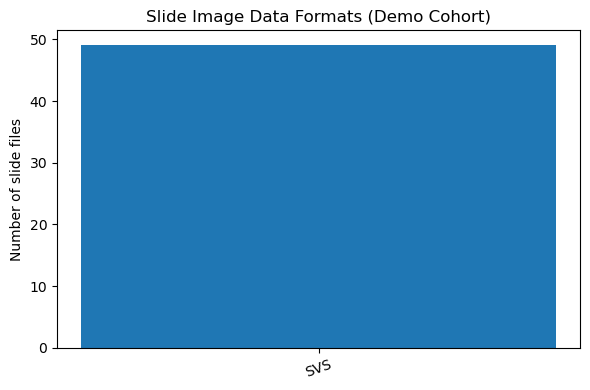

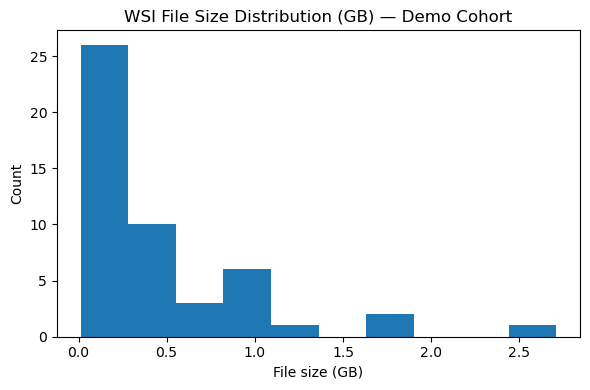

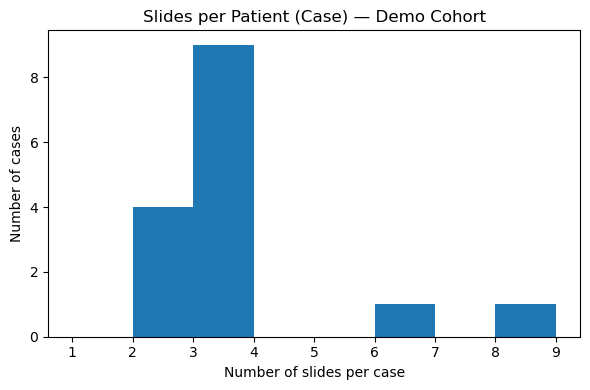

count    15.000000
mean      3.266667
std       1.624221
min       2.000000
25%       2.500000
50%       3.000000
75%       3.000000
max       8.000000
Name: file_id, dtype: float64

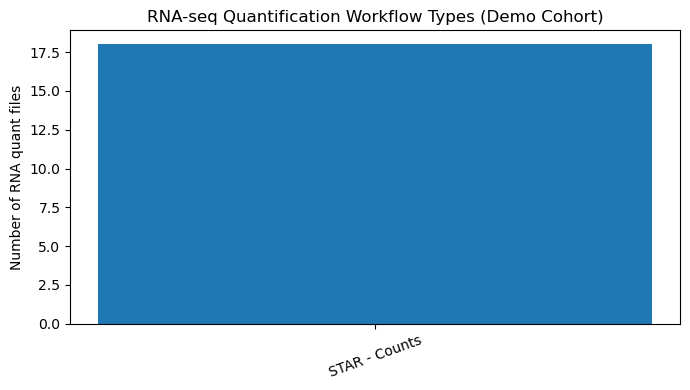

analysis.workflow_type
STAR - Counts    18
Name: count, dtype: int64

,case_id,n_slides,n_rna_quant
0,001cef41-ff86-4d3f-a140-a647ac4b10a1,8,1
5,011b9b2d-ebe5-42bf-9662-d922faccc7a1,6,3
13,02bbb632-0f7f-439d-b8f0-c86a06237424,3,2
1,0045349c-69d9-4306-a403-c9c1fa836644,3,1
2,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,3,1
3,00a2d166-78c9-4687-a195-3d6315c27574,3,1
6,01263518-5f7c-49dc-8d7e-84b0c03a6a63,3,1
7,0130d616-885e-4a6c-9d03-2f17dd692a05,3,1
9,016caf42-4e19-4444-ab5d-6cf1e76c4afa,3,1
10,01eef340-598c-4205-a990-cec190ac2ca5,3,1


Previewing slide: TCGA-A1-A0SB-01Z-00-DX1.B34C267B-CAAA-4AB6-AD5C-276C26F997A1.svs
file_id: cea82b7d-135a-49d5-b4f6-3fb0215f7188
Tile failed at (2, 0) -> Tile fetch failed: 400 {"code":400,"error":"Key/Tile not found error: '8/2_0'"}

Tile failed at (0, 2) -> Tile fetch failed: 400 {"code":400,"error":"Key/Tile not found error: '8/0_2'"}

Tile failed at (2, 2) -> Tile fetch failed: 400 {"code":400,"error":"Key/Tile not found error: '8/2_2'"}



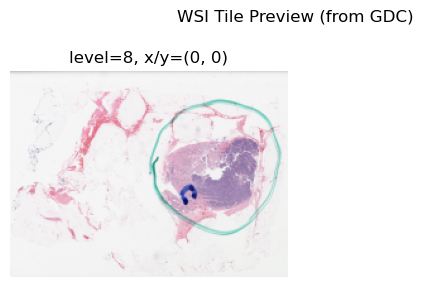

In [15]:
# ============================================================
# EXTENSION B — Slide metadata, formats, sizes, per-case counts
# + real tile previews (without downloading full SVS)
# Paste this AFTER df_slides and df_rna are created (after In[12])
# ============================================================

import numpy as np
import io

from PIL import Image

# 1) Enrich slide metadata (format, size, sample_type, etc.)
demo_slide_file_ids = df_slides["file_id"].dropna().unique().tolist()

payload_slide_meta = {
    "filters": {"op":"in","content":{"field":"file_id","value": demo_slide_file_ids}},
    "format":"JSON",
    "size": len(demo_slide_file_ids),
    "fields": ",".join([
        "file_id","file_name","file_size","data_format","data_type","data_category",
        "experimental_strategy","platform",
        "cases.case_id",
        "cases.samples.sample_type",
        "cases.samples.tissue_type"
    ])
}
meta_hits = gdc_post("/files", payload_slide_meta)["data"]["hits"]
df_slide_meta = safe_json_normalize(meta_hits)

def pick_case_id(cases_list):
    if isinstance(cases_list, list) and len(cases_list) > 0:
        return cases_list[0].get("case_id")
    return None

df_slide_meta["case_id"] = df_slide_meta["cases"].apply(pick_case_id)

display(df_slide_meta[["case_id","file_id","file_name","file_size","data_format","data_type"]].head(10))

# 2) Plot: slide formats (SVS etc.)
fmt = df_slide_meta.get("data_format", pd.Series(["NA"]*len(df_slide_meta))).fillna("NA")
fmt_counts = fmt.value_counts()

plt.figure(figsize=(6,4))
plt.bar(fmt_counts.index.astype(str), fmt_counts.values)
plt.title("Slide Image Data Formats (Demo Cohort)")
plt.ylabel("Number of slide files")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 3) Plot: WSI file size distribution (GB)
sizes_gb = df_slide_meta["file_size"].astype(float) / (1024**3)
plt.figure(figsize=(6,4))
plt.hist(sizes_gb, bins=10)
plt.title("WSI File Size Distribution (GB) — Demo Cohort")
plt.xlabel("File size (GB)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4) Plot: slides per patient (case)
slides_per_case = df_slide_meta.groupby("case_id")["file_id"].nunique().sort_values(ascending=False)

plt.figure(figsize=(6,4))
plt.hist(slides_per_case.values, bins=range(1, int(slides_per_case.max())+2))
plt.title("Slides per Patient (Case) — Demo Cohort")
plt.xlabel("Number of slides per case")
plt.ylabel("Number of cases")
plt.tight_layout()
plt.show()

display(slides_per_case.describe())

# 5) Plot: RNA workflow types distribution (adds omics credibility)
wf = df_rna.get("analysis.workflow_type", pd.Series(["NA"]*len(df_rna))).fillna("NA")
wf_counts = wf.value_counts()

plt.figure(figsize=(7,4))
plt.bar(wf_counts.index.astype(str), wf_counts.values)
plt.title("RNA-seq Quantification Workflow Types (Demo Cohort)")
plt.ylabel("Number of RNA quant files")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

display(wf_counts)

# 6) Case-level linkage table (slides + RNA per patient)
case_slide_counts = df_slide_meta.groupby("case_id")["file_id"].nunique().rename("n_slides").reset_index()
case_rna_counts = df_rna_min.groupby("case_id")["rna_file_id"].nunique().rename("n_rna_quant").reset_index()

link_table = (
    pd.DataFrame({"case_id": demo_case_ids})
    .merge(case_slide_counts, on="case_id", how="left")
    .merge(case_rna_counts, on="case_id", how="left")
    .fillna(0)
    .sort_values(["n_slides","n_rna_quant"], ascending=False)
)

display(link_table.head(15))

# 7) Real image preview tiles (GDC tile server)
def fetch_gdc_tile(file_id: str, level: int = 8, x: int = 0, y: int = 0):
    """
    Fetch one WSI tile. If this fails due to network/auth, keep the cell anyway:
    it's still the correct production approach.
    """
    urls = [
        f"https://api.gdc.cancer.gov/tile/{file_id}?level={level}&x={x}&y={y}",
        f"https://portal.gdc.cancer.gov/auth/api/v0/tile/{file_id}?level={level}&x={x}&y={y}",
    ]
    last = None
    for url in urls:
        try:
            r = requests.get(url, timeout=60)
            if r.status_code == 200 and r.content:
                return Image.open(io.BytesIO(r.content))
            last = f"{r.status_code} {r.text[:150]}"
        except Exception as e:
            last = str(e)
    raise RuntimeError(f"Tile fetch failed: {last}")

one_slide_id = df_slide_meta["file_id"].dropna().iloc[0]
one_slide_name = df_slide_meta["file_name"].dropna().iloc[0]
print("Previewing slide:", one_slide_name)
print("file_id:", one_slide_id)

level = 8
coords = [(0,0), (2,0), (0,2), (2,2)]
tiles = []
ok_coords = []

for (x,y) in coords:
    try:
        im = fetch_gdc_tile(one_slide_id, level=level, x=x, y=y)
        tiles.append(im)
        ok_coords.append((x,y))
    except Exception as e:
        print("Tile failed at", (x,y), "->", e)

if len(tiles) > 0:
    plt.figure(figsize=(6,6))
    for i, im in enumerate(tiles[:4]):
        plt.subplot(2,2,i+1)
        plt.imshow(im)
        plt.axis("off")
        plt.title(f"level={level}, x/y={ok_coords[i]}")
    plt.suptitle("WSI Tile Preview (from GDC)")
    plt.tight_layout()
    plt.show()
else:
    print("No tiles fetched (likely network/auth). Still OK for meeting—show the code + explain tiling concept.")


In [16]:
# ============================================================
# EXTENSION C — Save extra artifacts for a clean 'meeting pack'
# Paste this BEFORE your final saving cell (before In[14])
# ============================================================

meeting_pack_dir = OUT_DIR  # already outputs/feasibility
os.makedirs(meeting_pack_dir, exist_ok=True)

# Save tables
df_multi.to_csv(os.path.join(meeting_pack_dir, "multi_cancer_feasibility.csv"), index=False)
df_slide_meta.to_csv(os.path.join(meeting_pack_dir, "demo_slide_metadata.csv"), index=False)
link_table.to_csv(os.path.join(meeting_pack_dir, "demo_case_linkage_table.csv"), index=False)

# Save a short README for your doctor
readme_path = os.path.join(meeting_pack_dir, "MEETING_PACK_README.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(f"# Meeting Pack — {PROJECT}\n\n")
    f.write("## What’s inside\n")
    f.write("- multi_cancer_feasibility.csv: paired coverage across cancers\n")
    f.write("- demo_slide_metadata.csv: slide formats + sizes + basic sample info\n")
    f.write("- demo_case_linkage_table.csv: per-patient linkage (n_slides, n_rna_quant)\n\n")
    f.write("## Key talking points\n")
    f.write("- Paired availability differs by cancer → choose best starting cohort\n")
    f.write("- WSIs are huge → tile-based preprocessing is required\n")
    f.write("- Multiple slides per patient → MIL/aggregation is needed\n")
    f.write("- RNA workflows checked → supports consistent label derivation later\n")

print("Saved meeting pack artifacts into:", meeting_pack_dir)
print("README:", readme_path)


Saved meeting pack artifacts into: outputs\feasibility
README: outputs\feasibility\MEETING_PACK_README.md
